In [ ]:
# https://github.com/anjesh/Jupyter-GeoJson-Mapping
# https://www.ryanbaumann.com/blog/2016/4/3/embedding-mapbox-plots-in
#https://github.com/jwass/geojsonio.py-jupyter-notebooks
# http://jupyter-gmaps.readthedocs.io/en/latest/gmaps.html
#https://github.com/planetlabs/planet-client-python

# Setup 
Let's setup our environment. We'll pull in the the usual gis suspects and setup a leaflet map, read our API keys from a json file, and setup our Planet client

In [1]:
# See requirements.txt to set up your dev environment.
from planet import api
from planet.api import filters
from sys import stdout
import pandas as pd
import sys
import os
import json
import urllib
import numpy as np
import seaborn as sns
import rasterio
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import subprocess
import datetime 
import os.path
from scipy import ndimage
from osgeo import gdal
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from traitlets import link

from IPython.display import display, Image, HTML
%matplotlib inline

# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])


# Make a slippy map to get GeoJSON

* The planet API allows you to query using a [geojson](https://en.wikipedia.org/wiki/GeoJSON) which is a special flavor of json.
* We are going to create a slippy map using leaflet and apply the Planet 2017 Q1 mosaic as the basemap. This requires our api key.
* We are going to add a special draw handler that shoves a draw region into a object so we get the geojson.
* If you don't want to do this, or need a fixed query try [geojson.io](http://geojson.io/#map=2/20.0/0.0)
* To install and run:
```
$ pip install ipyleaflet
$ jupyter nbextension enable --py --sys-prefix ipyleaflet
```
* [More information](https://github.com/ellisonbg/ipyleaflet)

In [2]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 11
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

# Querying the Planet API.
* First we'll grab our geojson area of interest (AOI) and use it to construct a query.
* We'll then build a search to search that area looking for PSScene3Band
* We have lots of products: RapidEye, PlanetScope (PS) 3 and 4 band, LandSat, and Sentinel are all possible.
* Once we have our query, we'll do the search. We will then iterate over the results, slurp up the data, and put them in a pandas data frame for easy sorting.
* We'll print the first few so we're sure it works. 

In [78]:
print AOIs[1]
myAOI = AOIs[1]["geometry"]

# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes
query = filters.and_filter(
    filters.geom_filter(myAOI),
    filters.range_filter('cloud_cover', gt=0),
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=None):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
scenes.head()

{u'geometry': {u'type': u'Polygon', u'coordinates': [[[-122.6927948067896, 45.5188021557976], [-122.6927948067896, 45.54958511998541], [-122.6591491769068, 45.54958511998541], [-122.6591491769068, 45.5188021557976], [-122.6927948067896, 45.5188021557976]]]}, u'type': u'Feature', u'properties': {}}


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,geometry,ground_control,gsd,id,instrument,...,quality_category,rows,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle
0,2017-04-18T18:13:54.657796Z,0.32,0.59,9094,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942415,20170418_181354_0f25,PS2,...,test,4653,0f25,471379,135.2,47.7,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19T08:43:54Z,0,0.7
1,2017-04-18T18:13:53.601975Z,0.15,0.46,9093,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942612,20170418_181353_0f25,PS2,...,test,4654,0f25,471379,135.3,47.6,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19T08:12:00Z,0,0.7
2,2017-04-18T00:30:20.414098Z,0.00,0.32,4849,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,2.977989,20170418_003020_0c75,PS2,...,standard,6753,0c75,470582,259.4,25.3,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-18T20:48:33Z,0,1.4
3,2017-04-18T00:30:21.183098Z,0.00,0.21,4848,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,2.977809,20170418_003021_0c75,PS2,...,standard,6753,0c75,470582,259.5,25.2,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-18T20:48:33Z,0,1.4
4,2017-04-14T18:13:09.414633Z,0.48,0.69,9168,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.973864,20170414_181309_100c,PS2,...,test,4702,100c,468057,135.8,46.3,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-16T19:35:06Z,0,0.8


# Cleanup
* The data we got back is good, but we need some more information
* We got back big scenes, but we only care about our area of interest. The scene may not cover the whole area of interest.
* We can use the [Shapely](http://toblerity.org/shapely/manual.html) library to quickly figure out how much each scene overlaps our AOI
* We will convert our AOI and the geometry of each scene to calculate overlap using a shapely call.
* The returned acquisition, publish, and update times are strings, we'll convert them to datatime objects so we wan search.

In [79]:
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
scenes.head()

,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,geometry,ground_control,gsd,id,instrument,...,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle,overlap,footprint
0,2017-04-18 18:13:54.657796,0.32,0.59,9094,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942415,20170418_181354_0f25,PS2,...,0f25,471379,135.2,47.7,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19 08:43:54,0,0.7,94.113424,POLYGON ((-122.7430428486542 45.55898374689193...
1,2017-04-18 18:13:53.601975,0.15,0.46,9093,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.942612,20170418_181353_0f25,PS2,...,0f25,471379,135.3,47.6,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-19 08:12:00,0,0.7,29.392577,POLYGON ((-122.7211617696197 45.62499466650908...
2,2017-04-18 00:30:20.414098,0.00,0.32,4849,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,2.977989,20170418_003020_0c75,PS2,...,0c75,470582,259.4,25.3,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-18 20:48:33,0,1.4,16.981319,"POLYGON ((-122.664838565134 45.51991072394163,..."
3,2017-04-18 00:30:21.183098,0.00,0.21,4848,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,2.977809,20170418_003021_0c75,PS2,...,0c75,470582,259.5,25.2,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-18 20:48:33,0,1.4,1.886185,POLYGON ((-122.6048495050054 45.49622676443175...
4,2017-04-14 18:13:09.414633,0.48,0.69,9168,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",True,3.973864,20170414_181309_100c,PS2,...,100c,468057,135.8,46.3,https://api.planet.com/data/v1/item-types/PSSc...,2017-04-16 19:35:06,0,0.8,26.797464,"POLYGON ((-122.658423192118 45.56328951316318,..."


# Filtering our search using pandas.
* Using our dataframe we will filter the scenes to just what we want.
* First we want scenes with less than 10% clouds.
* Second we want standard quality images. Test images may not be high quality.
* Third well only look for scenes since February.
* Finally we will create a new data frame with our queries and print the results. 

In [77]:
# Now let's get it down to just good, recent, clear scenes
clear = scenes['cloud_cover']<0.1
good = scenes['quality_category']=="standard"
recent = scenes["acquired"] > datetime.date(year=2017,month=1,day=1)
partial_coverage = scenes["overlap"] > 30
good_scenes = scenes[(good&clear&recent&partial_coverage)]
good_scenes
# Now let's get it down to just good, recent, clear scenes
clear = scenes['cloud_cover']<0.1
good = scenes['quality_category']=="standard"
all_time = scenes["acquired"] > datetime.date(year=2015,month=1,day=1)
full_coverage = scenes["overlap"] >= 100
all_scenes = scenes[(good&clear&recent&full_coverage)]
all_scenes



,acquired,anomalous_pixels,cloud_cover,columns,epsg_code,geometry,ground_control,gsd,id,instrument,...,satellite_id,strip_id,sun_azimuth,sun_elevation,thumbnail,updated,usable_data,view_angle,overlap,footprint
18,2017-02-13 18:19:23.607619,0.01,0.01,9093,32610,"{u'type': u'Polygon', u'coordinates': [[[-122....",NaN,3.936015,20170213_181923_0e14,PS2,...,0e14,409944,146.0,25.0,https://api.planet.com/data/v1/item-types/PSSc...,2017-03-31 05:40:02,0,0.2,100.0,POLYGON ((-122.8446685601367 45.58925658371648...


# Let's see what we got. 
* The API returns a handy thumbnail link.
* Let's tell jupyter to show it.
* You may need to login to planet explorer to have auth. 
    * If this is the case just print the urls and paste them into your browser.

In [7]:
imgs = []
for img in good_scenes["thumbnail"].tolist():
    imgs.append(Image(url=img))
    print img
display(*imgs)

https://api.planet.com/data/v1/item-types/PSScene3Band/items/20170319_182053_0e14/thumb
https://api.planet.com/data/v1/item-types/PSScene3Band/items/20170319_182052_0e14/thumb
https://api.planet.com/data/v1/item-types/PSScene3Band/items/20170213_181923_0e14/thumb


# Product Activation and Downloading
* Full resolution uncompressed satellite images are *big* and there are lots of ways to view them.
* For this reason Planet generally keeps images in their native format and only processes them on customer requests. There is some caching of processed scenes, but this is the exception not the rule.
* All images must be activated prior to downloading and this can take some time based on demand.
* Additionally we need to determine what sort of product we want to download. Generally speaking there are three kinds of scenes:
    * Analytic - multi-band full resolution images that have not been processed. These are like raw files for DSLR camers.
    * Visual - these are color corrected rectified tifs. If you are just starting out this is your best call.
    * UDM - Usable data mask. This mask can be used to find bad pixels and columns and to mask out areas with clouds.
    

In [8]:
def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True

# Scenes ACTIVATE!
* Given our good scenes list we will convert the data frame "id" column into a list and activate every item in that list. 
* For this example we are going to default to using a 3Band visual product but I have included some four band methods to help you out.
* Activation usually takes about 5-15 minutes so get some coffee.

In [9]:
to_get = good_scenes["id"].tolist()
activated = []
waiter = []
for scene in to_get:
    product_types = get_products(client,scene)
    for p in product_types:
        if p == "visual": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

Activating visual for scene 20170319_182053_0e14
Activating visual for scene 20170319_182052_0e14
Activating visual for scene 20170213_181923_0e14


# Download Scenes
* In this section we will see if our scenes have been activated.
* If they are activated the client object will have its status flag set to active.
* Once that is done we will then save the scenes to the local directory.
* A smart engineer would set a path variable to store these files and check if the asset has already been downloaded prior to downloading

In [10]:
tiff_files = []
import urllib3
urllib3.disable_warnings()
#if scenes_are_active(activated):
for to_download,name in zip(activated,to_get):
    if( os.path.isfile(name + ".tif") ):
        tiff_files.append(name+".tif")
    elif to_download["status"] == "active":
        print "Downloading {0}....".format(name+".tif")
        fname = download_and_save(client,to_download)
        tiff_files.append(fname)
        print "Download done."
    else:
        print "Could not download, still activating"
#else:
#    print "Scenes aren't ready yet"

print tiff_files 
        

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


Download done.
Download done.
Download done.
['20170319_182053_0e14_3B_Visual.tif', '20170319_182052_0e14_3B_Visual.tif', '20170213_181923_0e14_3B_Visual.tif']


# Loading Images
* There are a varitety of ways to load tif data including Rasterio, GDAL, OpenCV, SKImage. 
* Today we are going to use rasterio and load each channel into a numpy array.
* Since the visual 3Band products are rotated we can also open a mask layer for processing.

In [14]:
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])
        
def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([b, g, r])
        
def get_mask(filename):
    """Return a 1D mask numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b,g,r,mask = src.read()
            return np.dstack([mask])

def rgbir_to_rgb(img_4band):
    """Convert an RGBIR image to RGB"""
    return img_4band[:,:,:3]

# Read Images and Use Matplotlib to show them.

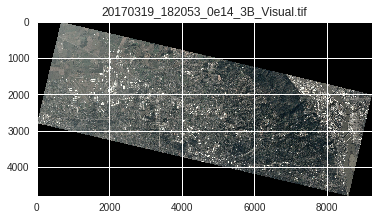

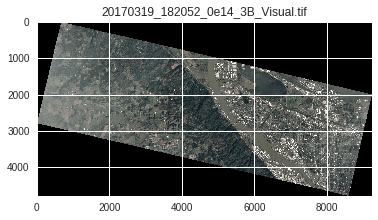

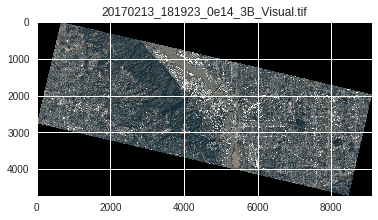

In [15]:
img_files = []
masks = []
for fname in tiff_files:
    img_files.append(load_image3(fname))
    masks.append(get_mask(fname))
i = 0
for img,name in zip(img_files,tiff_files):
    plt.figure(i,figsize=(6,12))
    plt.imshow(img)
    plt.title(name)
    i+=1

# Quick Histogram
* Next up we'll plot the histogram of the image.

In [ ]:
import numpy.ma as ma
def plot_hist4(img_4band,title=""):
    r, g, b, nir = img_4band[:, :, 0], img_4band[:, :, 1], img_4band[:, :, 2], img_4band[:, :, 3]
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
        plt.hist(slice_.ravel(), bins=100, 
                 range=[0,img_4band.max()], 
                 label=name, color=color, histtype='step')
    plt.title(title)
    plt.legend()
    
def plot_hist3(img_3band,mask,title=""):
    r, g, b = img_3band[:, :, 0], img_3band[:, :, 1], img_3band[:, :, 2]
    r = ma.masked_array(r,mask=mask)
    g = ma.masked_array(g,mask=mask)
    b = ma.masked_array(b,mask=mask)
    for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue')):
        plt.hist(slice_.ravel(), bins=25, 
                 range=[0,img_3band.max()], 
                 label=name, color=color, histtype='step')
    plt.title(title)
    plt.legend()

In [ ]:
i = 0
for img,name,mask in zip(img_files,tiff_files,masks):
    plt.figure(i)
    plot_hist3(img,mask=mask,title=name)
    i+=1

# Decomposing Channels
* We can also decompose the channels of the image. 
* Sometimes it is useful to work just in a single channel.
* Other times channels can be used to do useful things, like filter out clouds.


In [ ]:
def plot_bands4(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 3)
    r, g, b, nir = img[:, :, 0], img[:, :, 1], img[:, :, 2], img[:, :, 3]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)
        
def plot_bands3(img,title="",i=0):
    fig = plt.figure(i)
    fig.set_size_inches(24, 5)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    fig.suptitle(title)
    for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(c)
        plt.imshow(x)        

In [ ]:
i = 0
for img,name in zip(img_files,tiff_files):
    plot_bands3(img,title=name,i=i)
    i+=1

# But all of these scenes are big, and we want downtown Portland 
* We can clip all of the scenes to the AOI we selected at the start of the notebook
* First we'll dump the geojson to a file.
* Since geospatial data is "big" we often work with files and get stuff out of memory ASAP.
* For each of our scenes we'll create a 'clip' file.
* We will use a tool called GDAL to clip the scene to our AOI
* GDAL stands for [Geospatial Data Abstraction Library](http://www.gdal.org/)
* GDAL is a C++ library that is often run from the command line, but it does have SWIG bindings.

In [42]:
aoi_file ="portland.geojson" 
options = ['-t_srs','EPSG:3857', # the projection we will use
           '-cutline', aoi_file, # the file we want to use for clipping
           '-tap',# align to our box./
           '-tr', '3', '3'] # the output resolution.
with open(aoi_file,"w") as f:
    f.write(json.dumps(myAOI))
clip_names = []
for tiff in tiff_files:
    clip_names.append(os.path.abspath(tiff[:-4]+"_clip"+".tif"))
full_tif_files = []
for tiff in tiff_files:
    full_tif_files.append(os.path.abspath("./"+tiff))
for in_file,out_file in zip(tiff_files,clip_names):
    derp = gdal.Warp(out_file,in_file,cutlineDSName=aoi_file,cropToCutline=True,dstSRS = 'EPSG:3857', options = options)

# Awesome, Let's take a look at what we got.

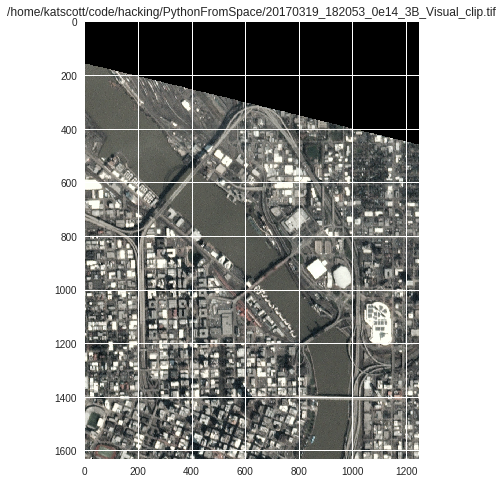

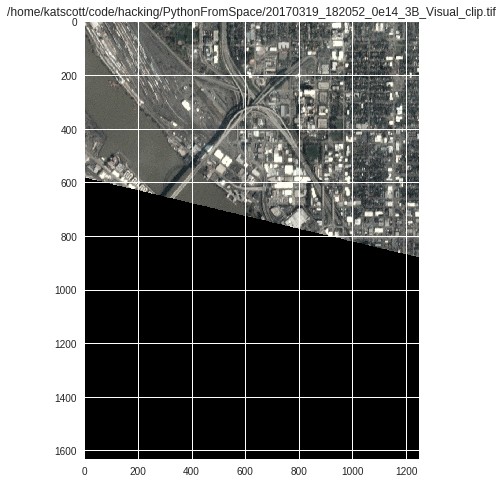

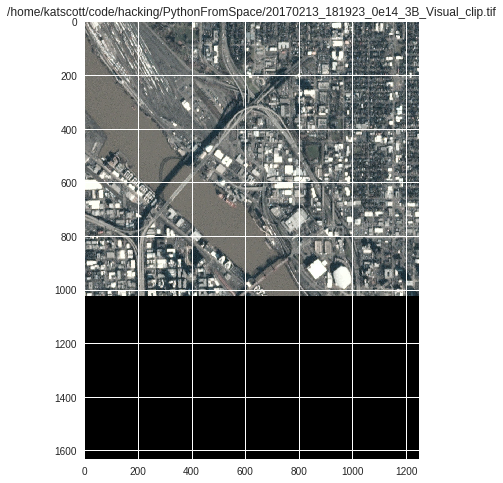

In [43]:
clip_img_files = []
masks = []
for fname in clip_names:
    clip_img_files.append(load_image3(fname))
i = 0
for img,name in zip(clip_img_files,clip_names):
    plt.figure(i,figsize=(6,12))
    plt.imshow(img)
    plt.title(name)
    i+=1

# Hrm... that's not right.
* You'll notice that a lot of these scenes don't fill our AOI.
* A lot of theses images were taken roughly at the same time.
* We should try to merge these scenes together to make one big scene.
* This process is called mosaicking, and GDAL can help. 
* We will call GDAL from the command line using subprocess to do this for us.

# WE NEED AN IMAGE HERE.


In [46]:
commands = ["gdalwarp", # t
           "-t_srs","EPSG:3857",
           "-cutline",aoi_file,
           "-crop_to_cutline",
           "-tap",
            "-tr", "3", "3"
           "-overwrite"]
output_mosaic = "merged.tif"
for tiff in tiff_files[0:2]:
    commands.append(tiff)
commands.append(output_mosaic)
print commands
subprocess.call(commands)

['gdalwarp', '-t_srs', 'EPSG:3857', '-cutline', 'portland.geojson', '-crop_to_cutline', '-tap', '-tr', '3', '3-overwrite', '20170319_182053_0e14_3B_Visual.tif', '20170319_182052_0e14_3B_Visual.tif', 'merged.tif']


1

# Let's take a look.... looks much better

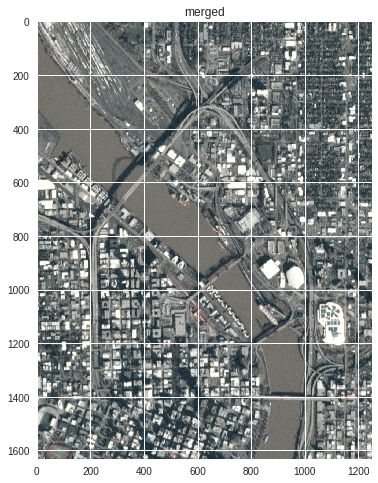

In [45]:
merged = load_image3("./merged.tif")
plt.figure(i,figsize=(6,12))
plt.imshow(merged)
plt.title("merged")

In [ ]:
#https://mapbox.s3.amazonaws.com/playground/perrygeo/rasterio-docs/cookbook.html
#/usr/local/lib/python2.7/dist-packages/rasterio/mask.py:72: UserWarning: GeoJSON outside bounds of existing output raster. Are they in different coordinate reference systems?
#  "reference systems?")
# https://gist.github.com/sgillies/8655640
#https://geohackweek.github.io/vector/04-geopandas-intro/
# https://github.com/dwtkns/gdal-cheat-sheet
# http://gis-pdx.opendata.arcgis.com/datasets/neighborhood-boundaries
#https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
# http://geospatialpython.com/2011/02/clip-raster-using-shapefile.html

94.1134244417
29.3925770458
16.9813187761
1.88618538053
26.797463716
2.55288050432
100.0
3.94712197407
100.0
2.32458620742
25.8543839643
40.0421386131
21.5279346752
97.3091141345
41.7379391092
80.5450214556
44.9960266294
100.0
100.0
100.0
0.013158247289
100.0
100.0
98.2104056529
11.4907619978
100.0
100.0
96.7402594092
100.0
35.6310711007
88.9725774818
48.9935313144
22.9645056536
38.7562182727
100.0
20.4814513824
99.9193611119
85.1312895158
100.0
46.7299758622
98.544523205
17.2869960641
99.5090509815
100.0
99.573955364
39.2429049411
93.350291502
8.31486034355
26.7228195179


0.000974744237376
0.000304422512165
0.00017587759364
1.95354524734e-05
0.000277544606292
2.64404953391e-05
0.00103571221976
4.08808246143e-05
0.00103571221976
2.4076023409e-05
0.000267777014062
0.000414721322669
0.000222967450092
0.00100784238603
0.00043228493563
0.000834214629623
0.000466029346206
0.00103571221976
0.00103571221976
0.00103571221976
1.36281575078e-07
0.00103571221976
0.00103571221976
0.00101717717242
0.000119011226155
0.00103571221976
0.00103571221976
0.00100195068813
0.00103571221976
0.000369035357421
0.000921499857213
0.000507431990714
0.000237846191261
0.000401402888567
0.00103571221976
0.000212128894751
0.00103487703294
0.000881715168353
0.00103571221976
0.000483988070296
0.00102063766874
0.000179043530665
0.00103062740078
0.00103571221976
0.0010312996234
0.000406443561863
0.000966840376266
8.6118024634e-05
0.000276771507211
